In [2]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !unzip glove.6B.zip

In [5]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [6]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
%cd /content/gdrive/MyDrive/Datasets/stanford-natural-language-inference-corpus/

/content/gdrive/MyDrive/Datasets/stanford-natural-language-inference-corpus


In [9]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Datasets/stanford-natural-language-inference-corpus/"

In [10]:
!kaggle datasets download -d stanfordu/stanford-natural-language-inference-corpus

stanford-natural-language-inference-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
datasetFolder = "stanford-natural-language-inference-corpus/"

In [12]:
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from tensorflow.keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

In [13]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
train_dataset = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_train.csv"))
test_dataset = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_test.csv"))
validation_dataset = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_dev.csv"))

In [15]:
full_dataset = [train_dataset, test_dataset, validation_dataset]
dataset = pd.concat(full_dataset)

In [16]:
dataset.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [17]:
dataset = dataset[['gold_label', 'sentence1', 'sentence2']]

In [18]:
len(dataset)

570152

In [19]:
dataset.isnull().sum()

gold_label    0
sentence1     0
sentence2     6
dtype: int64

In [20]:
dataset.describe()

,gold_label,sentence1,sentence2
count,570152,570152,570146
unique,4,157351,496642
top,entailment,A dog in a field.,A man is sleeping.
freq,190113,33,343


In [21]:
dataset.dropna(axis=0, inplace=True)

In [22]:
len(dataset)

570146

In [23]:
dataset = dataset.loc[dataset['gold_label'] != "-"]
dataset = dataset.loc[dataset['gold_label'] != "neutral"]

In [24]:
len(dataset)

379811

In [25]:
dataset = dataset.sample(frac = 1)

In [26]:
dataset.head()

,gold_label,sentence1,sentence2
502047,contradiction,A young woman paints on a large community mural.,A young woman walks by a large community mural
85789,contradiction,the unabomber on a fishing trip.,A cow is in a grassy field.
493866,contradiction,A group of African children display symbols wr...,A group of rich New York private school childr...
511160,contradiction,A girl playing softball slides into home plate,A girl is running towards first base.
188334,contradiction,A woman walking near a fast food restaurant.,A man is jogging past a fancy restaurant.


In [27]:
sentence1 = dataset['sentence1']
sentence2 = dataset['sentence2']
label = dataset['gold_label']

In [28]:
label.unique()

array(['contradiction', 'entailment'], dtype=object)

In [29]:
## To Clean the DATA Removing the stop words and making all the words to lower case.
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

In [30]:
sentence1 = CleanFeatures(sentence1)
sentence2 = CleanFeatures(sentence2)

In [31]:
sentence1.head()

502047             young woman paints large community mural
85789                                unabomber fishing trip
493866    group african children display symbols written...
511160              girl playing softball slides home plate
188334              woman walking near fast food restaurant
Name: sentence1, dtype: object

In [32]:
sentence2.head()

502047              young woman walks large community mural
85789                                      cow grassy field
493866    group rich new york private school children di...
511160                      girl running towards first base
188334                    man jogging past fancy restaurant
Name: sentence2, dtype: object

In [33]:
sentence1.shape

(379811,)

In [34]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape

(2, 379811)

In [35]:
all_sentences = all_sentences.reshape(-1,1 )

In [36]:
all_sentences = all_sentences.reshape(all_sentences.shape[0])

In [37]:
all_sentences.shape

(759622,)

In [38]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(all_sentences)

In [39]:
sentence1_seq = tokenizer.texts_to_sequences(sentence1)
sentence1 = pad_sequences(sentence1_seq)

In [40]:
sentence1.shape

(379811, 43)

In [41]:
sentence2_seq = tokenizer.texts_to_sequences(sentence2)
sentence2 = pad_sequences(sentence2_seq, maxlen= sentence1.shape[1])

In [42]:
sentence2.shape

(379811, 43)

In [43]:
sentence1

array([[   0,    0,    0, ...,   37, 2567,  998],
       [   0,    0,    0, ...,    0,  287, 1797],
       [   0,    0,    0, ...,  214,  161,   53],
       ...,
       [   0,    0,    0, ...,    9,  150,   94],
       [   0,    0,    0, ..., 4201,  209,   66],
       [   0,    0,    0, ...,   69,   14,   22]], dtype=int32)

In [44]:
label_ = LabelEncoder()
labels = label_.fit_transform(label)

In [45]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
vocabulary = len(tokenizer.word_index)

In [47]:
vocabulary

30607

In [48]:
labels = to_categorical(labels)

In [49]:
labels.shape

(379811, 2)

In [50]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [51]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape


(2, 379811, 43)

In [52]:
all_sentences = all_sentences.reshape(all_sentences.shape[1], 2, all_sentences.shape[2])

In [53]:
all_sentences.shape

(379811, 2, 43)

In [54]:
def glove_word_embedding(file_name, vocabulary):
  embeddings_index = {}
  file_ = open(file_name)
  for line in file_:
      arr = line.split()
      single_word = arr[0]
      w = np.asarray(arr[1:],dtype='float32')
      embeddings_index[single_word] = w
  file_.close()
  max_words = vocabulary + 1
  word_index = tokenizer.word_index
  embedding_matrix = np.zeros((max_words,300)).astype(object)
  for word , i in word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector 
  return embedding_matrix 

In [55]:
x = Input(shape=(all_sentences.shape[1], all_sentences.shape[2],))
p = TimeDistributed(Embedding(vocabulary + 1, 300))(x)
p = TimeDistributed(LSTM(128, return_sequences=True))(p)
p = TimeDistributed(LSTM(64, return_sequences=True))(p)
x1 = TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(p)
x2 = TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(p)
concat = tf.keras.layers.concatenate([x1, x2])
p = tf.keras.layers.Dropout(0.35)(concat)
p = Flatten()(p)
p = Dense(2, activation="softmax")(p)

In [56]:
m = tf.keras.models.Model(inputs = x, outputs = p)

In [57]:
m.layers[1].set_weights([glove_word_embedding("glove.6B.300d.txt", vocabulary)])
m.layers[1].trainable = False

In [58]:
m.compile(loss="binary_crossentropy",optimizer='adam',metrics=[TruePositives(name='tp'),
                                                                     FalsePositives(name='fp'),
                                                                     TrueNegatives(name='tn'),
                                                                     FalseNegatives(name='fn'),
                                                                     "accuracy",
                                                                     Precision(name='precision'),
                                                                     Recall(name='recall'),
                                                                     AUC(name = "AUC")])

In [59]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 60, mode = 'min', restore_best_weights = True)

In [60]:
history_training = m.fit(all_sentences,labels,
                         epochs= 100,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                         callbacks=[ earlyStopping])

Epoch 1/100
371/371 [==============================] - 32s 62ms/step - loss: 0.6933 - tp: 190092.0000 - fp: 189719.0000 - tn: 190092.0000 - fn: 189719.0000 - accuracy: 0.5005 - precision: 0.5005 - recall: 0.5005 - AUC: 0.5010
Epoch 2/100
371/371 [==============================] - 23s 62ms/step - loss: 0.6932 - tp: 190211.0000 - fp: 189599.0000 - tn: 190212.0000 - fn: 189600.0000 - accuracy: 0.5008 - precision: 0.5008 - recall: 0.5008 - AUC: 0.5013
Epoch 3/100
371/371 [==============================] - 23s 62ms/step - loss: 0.6931 - tp: 191512.0000 - fp: 188299.0000 - tn: 191512.0000 - fn: 188299.0000 - accuracy: 0.5042 - precision: 0.5042 - recall: 0.5042 - AUC: 0.5065
Epoch 4/100
371/371 [==============================] - 23s 61ms/step - loss: 0.6929 - tp: 193091.0000 - fp: 186719.0000 - tn: 193092.0000 - fn: 186720.0000 - accuracy: 0.5084 - precision: 0.5084 - recall: 0.5084 - AUC: 0.5124
Epoch 5/100
371/371 [==============================] - 23s 61ms/step - loss: 0.6926 - tp: 194925

In [61]:
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

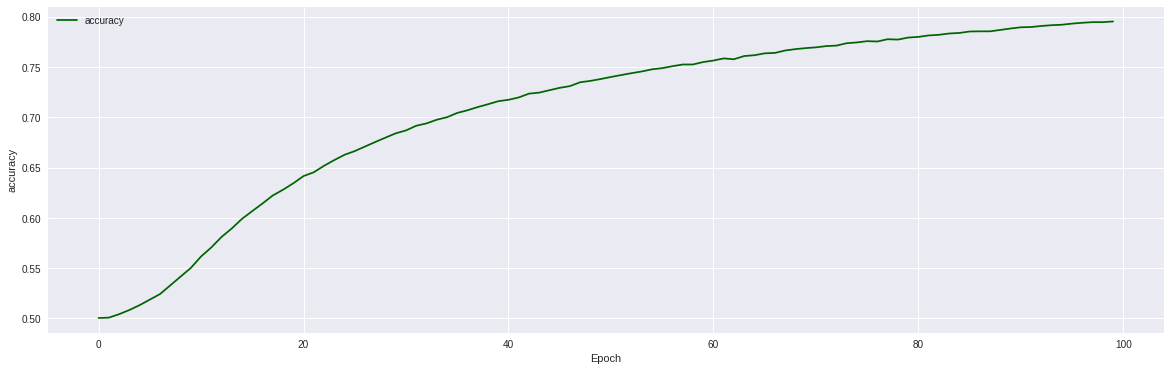

In [62]:
draw_plot(history_training.history['accuracy'],"darkgreen", "accuracy")

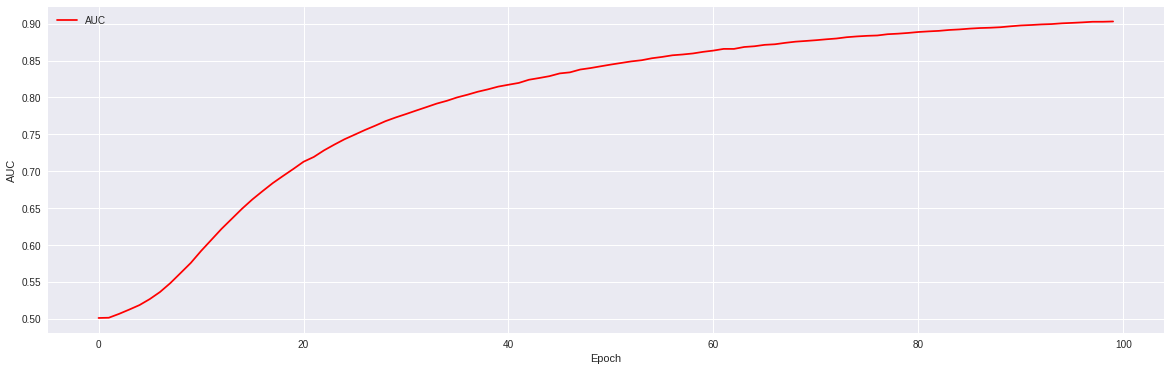

In [63]:
draw_plot(history_training.history['AUC'],"red", "AUC")

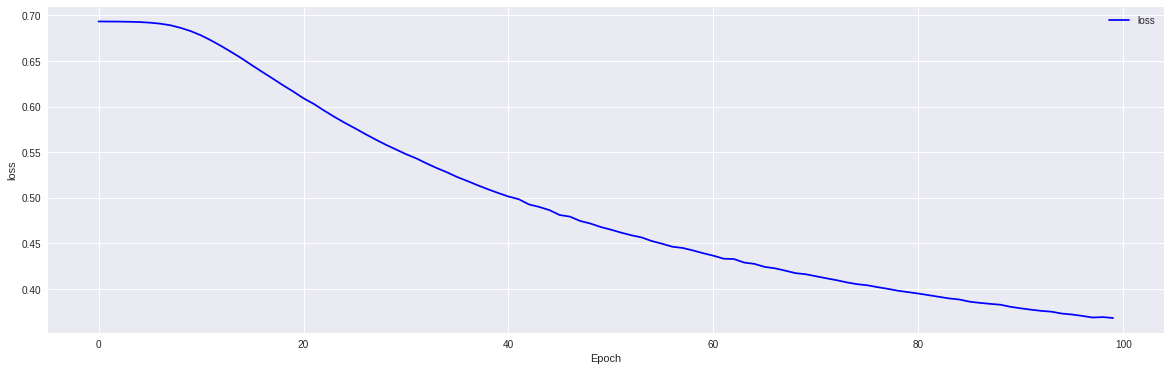

In [64]:
draw_plot(history_training.history['loss'],"blue", "loss")

In [65]:
m.evaluate(all_sentences,labels, batch_size = 1024,use_multiprocessing=True, workers = -1)


371/371 [==============================] - 10s 23ms/step - loss: 0.3306 - tp: 312762.0000 - fp: 67049.0000 - tn: 312762.0000 - fn: 67049.0000 - accuracy: 0.8235 - precision: 0.8235 - recall: 0.8235 - AUC: 0.9281


[0.330608993768692,
 312762.0,
 67049.0,
 312762.0,
 67049.0,
 0.8234674334526062,
 0.8234674334526062,
 0.8234674334526062,
 0.9281315207481384]

In [66]:
y_pred = m.predict(all_sentences, batch_size=1024, verbose= 1)
y_pred = np.argmax(y_pred, axis = 1)

371/371 [==============================] - 8s 20ms/step


In [67]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [68]:
y_test = np.argmax(labels, axis = 1)
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8234674614479307

In [70]:
res = tf.math.confusion_matrix(y_pred,y_test).numpy()

In [71]:
ConfusionMatrix = pd.DataFrame(res,
                     index = ['contradiction', 'entailment'], 
                     columns = ['contradiction', 'entailment'])
ConfusionMatrix

,contradiction,entailment
contradiction,157255,34604
entailment,32445,155507


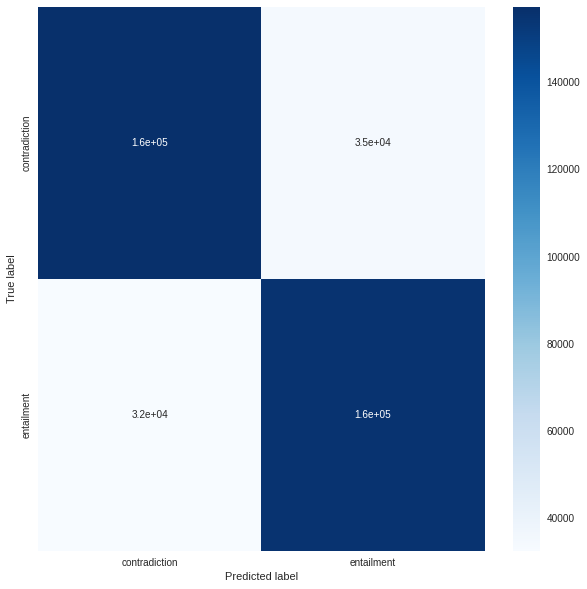

In [72]:
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(ConfusionMatrix, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Testing Part

In [73]:
## Example One
sen1 = "This church choir sings to the masses as they sing joyous songs from the book at a church."
sen2 = "The church has cracks in the ceiling."
def pre_processing_sentence(sentence):
  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  pred_input = [word for word in pred_input.split() if word not in stop_words]
  pred_input = ' '.join(pred_input)
  print(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],43)
  return pred_input
sen1 = pre_processing_sentence(sen1)
sen1
sen2 = pre_processing_sentence(sen2)
full_input = np.asarray([sen1, sen2])
full_input.shape
full_input = full_input.reshape(1, 2, 43)
full_input.shape
y_predict = m.predict(full_input)
y_predict
y_pred = np.argmax(y_predict)
classes_name = ['contradiction', 'entailment']
classes_name[y_pred]

church choir sings masses sing joyous songs book church
church cracks ceiling
1/1 [==============================] - 0s 24ms/step


'contradiction'

In [74]:
##Example Two
sen1 = "This church choir sings to the masses as they sing joyous songs from the book at a church."
sen2 = "The church is filled with song."
def pre_processing_sentence(sentence):
  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  pred_input = [word for word in pred_input.split() if word not in stop_words]
  pred_input = ' '.join(pred_input)
  print(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],43)
  return pred_input
sen1 = pre_processing_sentence(sen1)
sen1
sen2 = pre_processing_sentence(sen2)
full_input = np.asarray([sen1, sen2])
full_input.shape
full_input = full_input.reshape(1, 2, 43)
full_input.shape
y_predict = m.predict(full_input)
y_predict
y_pred = np.argmax(y_predict)
classes_name = ['contradiction', 'entailment']
classes_name[y_pred]

church choir sings masses sing joyous songs book church
church filled song
1/1 [==============================] - 0s 15ms/step


'contradiction'

In [75]:
#Example Three
sen1 = "A woman with a green headscarf, blue shirt and a very big grin."
sen2 = "The woman is very happy."
def pre_processing_sentence(sentence):
  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  pred_input = [word for word in pred_input.split() if word not in stop_words]
  pred_input = ' '.join(pred_input)
  print(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],43)
  return pred_input
sen1 = pre_processing_sentence(sen1)
sen1
sen2 = pre_processing_sentence(sen2)
full_input = np.asarray([sen1, sen2])
full_input.shape
full_input = full_input.reshape(1, 2, 43)
full_input.shape
y_predict = m.predict(full_input)
y_predict
y_pred = np.argmax(y_predict)
classes_name = ['contradiction', 'entailment']
classes_name[y_pred]

woman green headscarf blue shirt big grin
woman happy
1/1 [==============================] - 0s 16ms/step


'entailment'